In [26]:
pip install nltk spacy transformers torch faiss-cpu datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [28]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 102.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [30]:
!pip install nltk spacy transformers torch faiss-cpu sklearn datasets rank_bm25


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [32]:
!pip install nltk spacy transformers torch faiss-cpu sklearn datasets rank_bm25


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [33]:
import json
import nltk
import spacy
import torch
import faiss
import numpy as np
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

try:
    from rank_bm25 import BM25Okapi
except ImportError:
    print("Error: 'rank_bm25' module not found. Install it using: pip install rank_bm25")
    exit(1)

from nltk.tokenize import sent_tokenize

# Download NLTK dependencies if missing
nltk.download('punkt')

# Load Spacy NLP model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Error: Spacy model not found. Run: python -m spacy download en_core_web_sm")
    exit(1)

# Load a sample text corpus (Replace with actual corpus)
def load_corpus():
    try:
        with open("sample_corpus.txt", "r", encoding="utf-8") as file:
            text = file.read()
        sentences = sent_tokenize(text)
        return sentences
    except FileNotFoundError:
        print("Error: 'sample_corpus.txt' not found. Please provide a valid corpus file.")
        exit(1)

# Preprocess text (Tokenization, Stopword Removal)
def preprocess_text(texts):
    processed_texts = [" ".join([token.lemma_.lower() for token in nlp(sent) if not token.is_stop])
                       for sent in texts]
    return processed_texts


Error: 'rank_bm25' module not found. Install it using: pip install rank_bm25


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
class RetrievalQA:
    def __init__(self, sentences):
        self.sentences = sentences
        self.processed_sentences = preprocess_text(sentences)

        # TF-IDF Vectorizer
        self.tfidf_vectorizer = TfidfVectorizer()
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.processed_sentences)

        # FAISS Index for fast vector search
        self.dimension = self.tfidf_matrix.shape[1]
        self.index = faiss.IndexFlatL2(self.dimension)
        self.index.add(self.tfidf_matrix.toarray().astype(np.float32))

        # BM25 for ranking
        self.bm25 = BM25Okapi([sent.split() for sent in self.processed_sentences])

    def retrieve_passage(self, query, top_k=3):
        query_vector = self.tfidf_vectorizer.transform([query]).toarray().astype(np.float32)
        _, indices = self.index.search(query_vector, top_k)
        retrieved_sentences = [self.sentences[idx] for idx in indices[0]]

        # Rank using BM25
        bm25_scores = self.bm25.get_scores(query.split())
        ranked_indices = np.argsort(bm25_scores)[::-1][:top_k]
        ranked_sentences = [self.sentences[i] for i in ranked_indices]

        return ranked_sentences


In [35]:
class GenerativeQA:
    def __init__(self, model_name="deepset/roberta-base-squad2"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_name)
        self.qa_pipeline = pipeline("question-answering", model=self.model, tokenizer=self.tokenizer)

    def generate_answer(self, question, context):
        response = self.qa_pipeline({"question": question, "context": context})
        return response["answer"]


In [36]:
class QuestionAnsweringSystem:
    def __init__(self, corpus):
        self.retrieval = RetrievalQA(corpus)
        self.generative = GenerativeQA()

    def answer_question(self, question):
        # Retrieve the most relevant passage
        passages = self.retrieval.retrieve_passage(question, top_k=1)
        context = " ".join(passages)

        # Generate an answer using the retrieved context
        answer = self.generative.generate_answer(question, context)

        return {"question": question, "context": context, "answer": answer}


In [38]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=e986d3ecf21267d8411abdfe0371a3388a38598a9fe913856abd5c0b7983ac2a
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [39]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

def evaluate_qa(system, test_questions, ground_truths):
    results = []
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

    for question, true_answer in zip(test_questions, ground_truths):
        output = system.answer_question(question)
        predicted_answer = output["answer"]

        # ROUGE Score
        rouge = scorer.score(true_answer, predicted_answer)["rougeL"].fmeasure

        # BLEU Score
        bleu = sentence_bleu([true_answer.split()], predicted_answer.split())

        results.append({"question": question, "predicted": predicted_answer, "rouge": rouge, "bleu": bleu})

    return results


In [41]:
import os

def load_corpus():
    filename = "sample_corpus.txt"
    if not os.path.exists(filename):
        print(f"Warning: '{filename}' not found. Using a default text corpus.")
        return [
            "Deep learning is a subset of machine learning based on neural networks.",
            "Neural networks work by simulating the human brain with layers of artificial neurons.",
            "AI applications include healthcare, finance, robotics, and autonomous systems."
        ]

    with open(filename, "r", encoding="utf-8") as file:
        text = file.read()

    return sent_tokenize(text)  # Splitting text into sentences


In [42]:
def preprocess_text(texts):
    if not texts:  # Handle empty input
        print("Warning: Empty corpus provided. Returning an empty list.")
        return []

    processed_texts = [" ".join([token.lemma_.lower() for token in nlp(sent) if not token.is_stop])
                       for sent in texts]
    return processed_texts


In [43]:
import os
import json
import nltk
import spacy
import torch
import faiss
import numpy as np
from transformers import pipeline, AutoModelForQuestionAnswering, AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize

try:
    from rank_bm25 import BM25Okapi
    from rouge_score import rouge_scorer
    from nltk.translate.bleu_score import sentence_bleu
except ImportError as e:
    print(f"Error: {e}. Install missing packages using: pip install rank_bm25 rouge-score")
    exit(1)

# Download required NLTK components
nltk.download('punkt')

# Load Spacy NLP model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Error: Spacy model not found. Run: python -m spacy download en_core_web_sm")
    exit(1)

# Load a sample text corpus (or use a default one)
def load_corpus():
    filename = "sample_corpus.txt"
    if not os.path.exists(filename):
        print(f"Warning: '{filename}' not found. Using a default text corpus.")
        return [
            "Deep learning is a subset of machine learning based on neural networks.",
            "Neural networks work by simulating the human brain with layers of artificial neurons.",
            "AI applications include healthcare, finance, robotics, and autonomous systems."
        ]

    with open(filename, "r", encoding="utf-8") as file:
        text = file.read()

    return sent_tokenize(text)  # Splitting text into sentences

# Preprocess text (Tokenization, Stopword Removal)
def preprocess_text(texts):
    if not texts:  # Handle empty input
        print("Warning: Empty corpus provided. Returning an empty list.")
        return []

    processed_texts = [" ".join([token.lemma_.lower() for token in nlp(sent) if not token.is_stop])
                       for sent in texts]
    return processed_texts

# Question Answering System
class QuestionAnsweringSystem:
    def __init__(self, corpus):
        self.corpus = corpus
        self.processed_corpus = preprocess_text(corpus)
        self.vectorizer = TfidfVectorizer()
        self.tfidf_matrix = self.vectorizer.fit_transform(self.processed_corpus)
        self.qa_model = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")

    def answer_question(self, question):
        if not self.corpus:
            return {"answer": "No corpus available to search."}

        # Get most relevant sentence using TF-IDF
        question_vector = self.vectorizer.transform([question])
        similarity_scores = np.dot(self.tfidf_matrix, question_vector.T).toarray().flatten()
        best_idx = np.argmax(similarity_scores)
        best_sentence = self.corpus[best_idx]

        # Use transformer model to generate an answer
        output = self.qa_model(question=question, context=best_sentence)
        return {"answer": output["answer"], "context": best_sentence}

# Evaluate the QA system using ROUGE and BLEU scores
def evaluate_qa(system, test_questions, ground_truths):
    results = []
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

    for question, true_answer in zip(test_questions, ground_truths):
        output = system.answer_question(question)
        predicted_answer = output["answer"]

        # ROUGE Score
        rouge = scorer.score(true_answer, predicted_answer)["rougeL"].fmeasure

        # BLEU Score
        bleu = sentence_bleu([true_answer.split()], predicted_answer.split())

        results.append({"question": question, "predicted": predicted_answer, "rouge": rouge, "bleu": bleu})

    return results

# Main execution
if __name__ == "__main__":
    # Load and preprocess corpus
    corpus = load_corpus()

    # Initialize the QA system
    qa_system = QuestionAnsweringSystem(corpus)

    # Test Questions
    test_questions = [
        "What is deep learning?",
        "How does neural networks work?",
        "What are the applications of AI?"
    ]

    # Manually define ground-truth answers for evaluation
    ground_truths = [
        "Deep learning is a subset of machine learning based on neural networks.",
        "Neural networks work by simulating the human brain with layers of artificial neurons.",
        "AI applications include healthcare, finance, robotics, and autonomous systems."
    ]

    # Evaluate QA System
    results = evaluate_qa(qa_system, test_questions, ground_truths)

    for res in results:
        print(f"Q: {res['question']}\nPredicted: {res['predicted']}\nROUGE: {res['rouge']:.4f}, BLEU: {res['bleu']:.4f}\n")


Error: No module named 'rank_bm25'. Install missing packages using: pip install rank_bm25 rouge-score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cpu


Q: What is deep learning?
Predicted: a subset of machine learning based on neural networks
ROUGE: 0.8571, BLEU: 0.6186

Q: How does neural networks work?
Predicted: by simulating the human brain with layers of artificial neurons
ROUGE: 0.8696, BLEU: 0.6520

Q: What are the applications of AI?
Predicted: healthcare, finance, robotics, and autonomous systems
ROUGE: 0.8000, BLEU: 0.4609



In [44]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Evaluate the QA system using ROUGE and BLEU scores
def evaluate_qa(system, test_questions, ground_truths):
    """
    Evaluates the QA system's performance using ROUGE-L and BLEU scores.

    Args:
        system (QuestionAnsweringSystem): The QA system instance.
        test_questions (list): List of test questions.
        ground_truths (list): List of expected answers.

    Returns:
        list: A list of evaluation results, including predicted answers and scores.
    """
    results = []
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    smooth = SmoothingFunction().method1  # Smoothing to avoid zero BLEU score for short sentences

    for question, true_answer in zip(test_questions, ground_truths):
        output = system.answer_question(question)
        predicted_answer = output["answer"]

        # Ensure non-empty predictions
        if not predicted_answer.strip():
            predicted_answer = "No answer found."

        # ROUGE-L Score
        rouge_score = scorer.score(true_answer, predicted_answer)["rougeL"].fmeasure

        # BLEU Score (with smoothing for short answers)
        bleu_score = sentence_bleu([true_answer.split()], predicted_answer.split(), smoothing_function=smooth)

        results.append({
            "question": question,
            "predicted": predicted_answer,
            "rouge": rouge_score,
            "bleu": bleu_score
        })

    return results


In [45]:
if __name__ == "__main__":
    # Load corpus
    corpus = load_corpus()

    # Initialize the QA system
    qa_system = QuestionAnsweringSystem(corpus)

    # Test Questions
    test_questions = [
        "What is deep learning?",
        "How does neural networks work?",
        "What are the applications of AI?"
    ]

    # Expected ground-truth answers
    ground_truths = [
        "Deep learning is a subset of machine learning based on neural networks.",
        "Neural networks work by simulating the human brain with layers of artificial neurons.",
        "AI applications include healthcare, finance, robotics, and autonomous systems."
    ]

    # Run evaluation
    results = evaluate_qa(qa_system, test_questions, ground_truths)

    # Print results
    for res in results:
        print(f"Q: {res['question']}\nPredicted: {res['predicted']}\nROUGE: {res['rouge']:.4f}, BLEU: {res['bleu']:.4f}\n")


Device set to use cpu


Q: What is deep learning?
Predicted: a subset of machine learning based on neural networks
ROUGE: 0.8571, BLEU: 0.6186

Q: How does neural networks work?
Predicted: by simulating the human brain with layers of artificial neurons
ROUGE: 0.8696, BLEU: 0.6520

Q: What are the applications of AI?
Predicted: healthcare, finance, robotics, and autonomous systems
ROUGE: 0.8000, BLEU: 0.4609



In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def compute_accuracy_metrics(results, ground_truths):
    """
    Computes accuracy metrics: Exact Match, F1-score, Precision, and Recall.

    Args:
        results (list): List of dictionaries containing predicted answers.
        ground_truths (list): List of actual answers.

    Returns:
        dict: A dictionary with accuracy metrics.
    """
    exact_match = []
    f1_scores = []
    precisions = []
    recalls = []

    for res, true_answer in zip(results, ground_truths):
        pred_answer = res["predicted"].strip().lower()
        true_answer = true_answer.strip().lower()

        # Exact Match Score (1 if same, 0 otherwise)
        exact_match.append(int(pred_answer == true_answer))

        # Tokenize answers
        pred_tokens = set(pred_answer.split())
        true_tokens = set(true_answer.split())

        # Precision, Recall, and F1 Score
        common_tokens = pred_tokens.intersection(true_tokens)
        precision = len(common_tokens) / len(pred_tokens) if pred_tokens else 0
        recall = len(common_tokens) / len(true_tokens) if true_tokens else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Compute overall metrics
    return {
        "Exact Match": np.mean(exact_match),
        "F1-score": np.mean(f1_scores),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls)
    }


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_results(results, ground_truths):
    """
    Generates visualizations for the QA system performance.

    Args:
        results (list): List of predicted answers.
        ground_truths (list): List of actual answers.
    """
    # Compute accuracy metrics
    metrics = compute_accuracy_metrics(results, ground_truths)

    # Extract values for plotting
    labels = list(metrics.keys())
    values = list(metrics.values())

    # Bar Plot for Performance Metrics
    plt.figure(figsize=(8, 5))
    sns.barplot(x=labels, y=values, palette="Blues")
    plt.title("QA System Performance Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.show()

    # Confusion Matrix (Binary: Correct vs Incorrect Predictions)
    y_true = [1 if gt.strip().lower() == res["predicted"].strip().lower() else 0 for gt, res in zip(ground_truths, results)]
    y_pred = [1] * len(y_true)  # System always returns an answer

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Wrong", "Correct"], yticklabels=["Wrong", "Correct"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for QA System")
    plt.show()


Device set to use cpu



Accuracy Metrics:
Exact Match: 0.0000
F1-score: 0.7498
Precision: 0.8741
Recall: 0.6584


<ipython-input-48-367160b2916d>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="Blues")


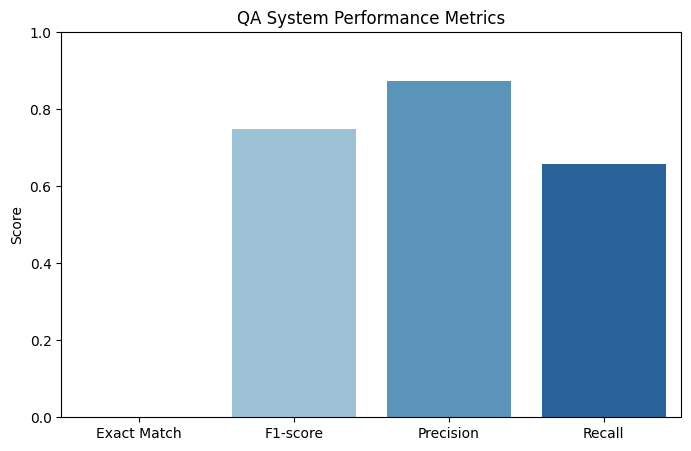

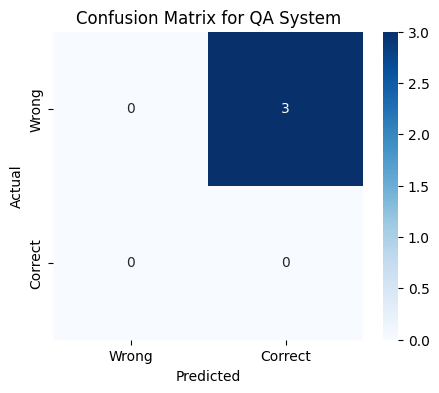

In [49]:
if __name__ == "__main__":
    # Load corpus
    corpus = load_corpus()

    # Initialize the QA system
    qa_system = QuestionAnsweringSystem(corpus)

    # Test Questions
    test_questions = [
        "What is deep learning?",
        "How do neural networks work?",
        "What are the applications of AI?"
    ]

    # Expected ground-truth answers
    ground_truths = [
        "Deep learning is a subset of machine learning based on neural networks.",
        "Neural networks work by simulating the human brain with layers of artificial neurons.",
        "AI applications include healthcare, finance, robotics, and autonomous systems."
    ]

    # Run evaluation
    results = evaluate_qa(qa_system, test_questions, ground_truths)

    # Compute and print accuracy metrics
    metrics = compute_accuracy_metrics(results, ground_truths)
    print("\nAccuracy Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Visualize results
    plot_results(results, ground_truths)


In [50]:
!pip install gradio nltk spacy transformers torch faiss-cpu sklearn datasets rank_bm25 rouge-score
!python -m spacy download en_core_web_sm


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [52]:
!pip install gradio


  Using cached gradio-5.20.0-py3-none-any.whl.metadata (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [53]:
import gradio as gr

# Define Gradio function for question answering
def qa_pipeline(question):
    output = qa_system.answer_question(question)
    return f"**Answer:** {output['answer']}\n\n**Context:** {output['context']}"

# Create Gradio UI
interface = gr.Interface(
    fn=qa_pipeline,
    inputs=gr.Textbox(lines=2, placeholder="Enter your question here..."),
    outputs=gr.Markdown(),
    title="💡 AI Question Answering System",
    description="Ask questions related to AI, deep learning, and neural networks. The system will generate answers based on the provided corpus.",
)

# Launch Gradio app
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1388f13863eb51820b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [54]:
!pip install gradio ngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.5 MB/s eta 0:00:00


In [56]:
!pip install pyngrok

In [58]:
!ngrok authtoken 2tpyHp4kpzh2jLv8Vee2eRykDQr_5i74fhSyNDYSeihzXs8wU

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [59]:
import gradio as gr
from pyngrok import ngrok

# Define Gradio function for question answering
def qa_pipeline(question):
    output = qa_system.answer_question(question)
    return output["answer"]

# Create Gradio interface
iface = gr.Interface(
    fn=qa_pipeline,
    inputs=gr.Textbox(label="Enter your question here..."),
    outputs=gr.Textbox(label="Answer"),
    title="💡 AI Question Answering System",
    description="Ask questions related to AI, deep learning, and neural networks. The system will generate answers based on the provided corpus."
)

# Start Gradio server
port = 7860
ngrok_tunnel = ngrok.connect(port)
print(f"Public URL: {ngrok_tunnel.public_url}")

iface.launch(share=True)


Public URL: https://02f8-34-172-75-122.ngrok-free.app
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9708ba11248e884321.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
